In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import matplotlib.colors as mcolors
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.ndimage import convolve
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [45]:
BeamE = []
PbGYield = []
PbGYieldErr = []
PbGRes = []
PbGResErr = []

In [72]:
energy = 8

input_file_name = 'Data/PbGl8GeV.pkl'

with open(input_file_name, 'rb') as file:
    dataframes_dict = pickle.load(file)
    


In [73]:
def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def resolution(x, A, b):
    return (A/np.sqrt(x)) + b

def lin(x, A, b):
    return (A*x) + b

In [74]:
hod_df = dataframes_dict['hod_df']
# Select ADC values for all channels
adc_values = hod_df[[f'ch_{i + 48}' for i in range(16)]].values

# Calculate y multiplicity
ymult = np.sum(adc_values[:, :8] > 0, axis=1)

# Calculate x multiplicity
xmult = np.sum(adc_values[:, 8:] > 0, axis=1)

# Calculate x and y positions

xpos_evt = []
ypos_evt = []

xpos = 100
ypos = 100
for evt in range(len(hod_df['ch_48'])):
    xpos = 100
    ypos = 100
    for i in range(8):
        if hod_df[f'ch_{i + 48}'][evt] > 0:
            for j in range(8):
                #hodoscope cutoff here
                if hod_df[f'ch_{j + 48 + 8}'][evt] > 0:
                    ypos = -16.8 + 4.8 * j
                    xpos = -16.8 + 4.8 * i
    xpos_evt.append(xpos)
    ypos_evt.append(ypos)
    
xpos_evt = np.array(xpos_evt)
ypos_evt = np.array(ypos_evt)

In [75]:
Sc1RawADCSpectrum = dataframes_dict['sc1_df']['ch_32']
Ce1RawADCSpectrum = dataframes_dict['ce1_df']['ch_35']
Ce2RawADCSpectrum = dataframes_dict['ce2_df']['ch_37']

PbGElectron = []

# Initialize arrays
ecutMask = np.zeros(len(hod_df['ch_48']), dtype=bool)

# Calculate the ecut array
ecut = (Sc1RawADCSpectrum < 1000) & (xmult == 1) & (ymult == 1) & (Ce1RawADCSpectrum > 0) & (Ce1RawADCSpectrum < 300) & (Ce2RawADCSpectrum == 0)
size = 1
positioncut = (-9.6*size < xpos_evt) & (xpos_evt < 9.6*size) & (-9.6*size < ypos_evt) & (ypos_evt < 9.6*size)

# Update ecutMask
ecutMask = ecut & positioncut

# Filter ECalSumElectron and ElectronEcalCh based on ecutMask
PbGElectron.append(dataframes_dict['pbg_df']['ch_34'][ecutMask])
PbGElectron = np.array(PbGElectron)

[83, 1612.875625733799, 164.62188412243034]


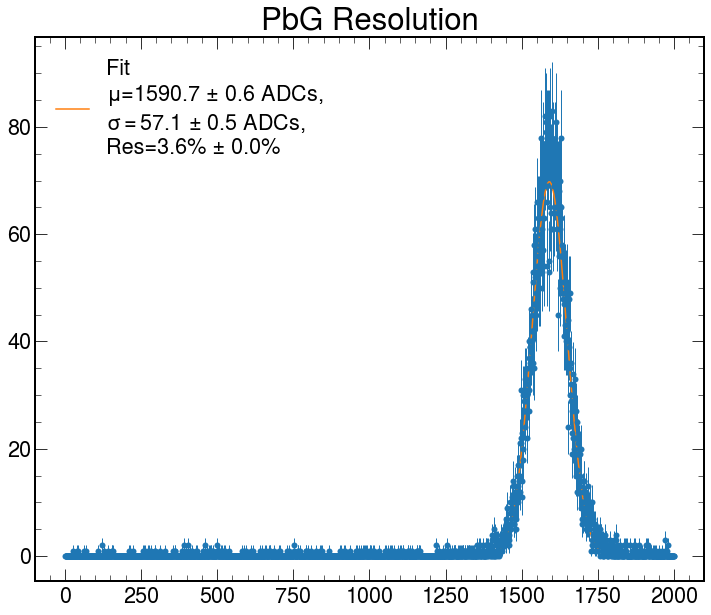

In [78]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

lowRange = 1
highRange = 2000
bins = highRange - lowRange
lowFit = 1300
highFit = 2000

h, bins = np.histogram(PbGElectron, bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)
initial_params = [max(h[mask]),np.mean(PbGElectron[PbGElectron > lowFit]),np.std(PbGElectron[PbGElectron > lowFit])]
print(initial_params)
m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']

x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = sigma_fit/mu_fit
res = np.sqrt((100*res)**2 - 1.8**2)

# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)

# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r

# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

plt.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
plt.legend()   
plt.title("PbG Resolution")

MeanElectron = mu_fit
MeanElectronErr = mu_err
ResElectron = res
ResElectronErr = delta_res


In [79]:
BeamE.append(energy)
PbGYield.append(MeanElectron)
PbGYieldErr.append(MeanElectronErr)
PbGRes.append(ResElectron)
PbGResErr.append(ResElectronErr)

In [80]:
print(BeamE)
print(PbGYield)
print(PbGRes)

[1, 2, 4, 8]
[231.58536687148361, 428.96464880471456, 823.824049953454, 1590.6627245276788]
[6.152434874285078, 5.0860460892742765, 4.356107512561119, 3.5922764248351076]


# Do not progress untill all energies are run

Text(0, 1, 'Yield Difference [%]')

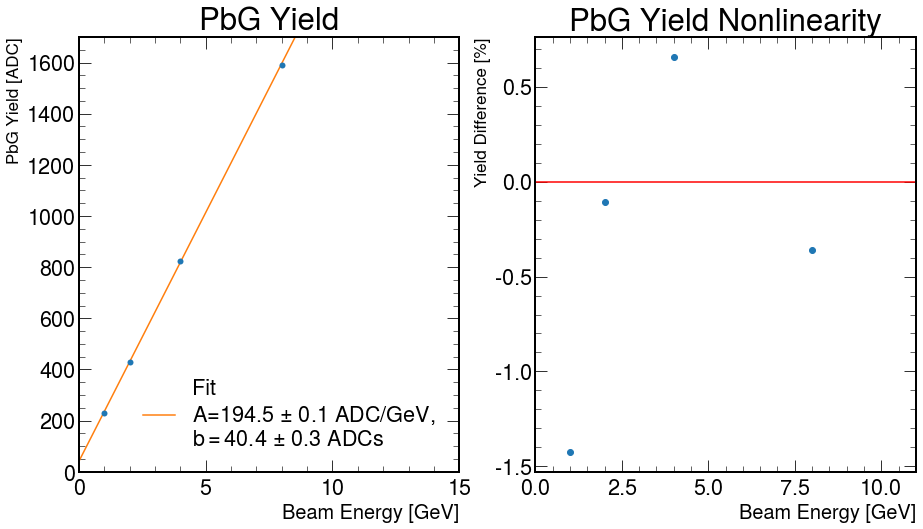

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].errorbar(BeamE, PbGYield, yerr=PbGYieldErr, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)
axs[0].set_xlim(0,15)
axs[0].set_ylim(0,1700)

axs[0].set_xlabel("Beam Energy [GeV]", size=20)
axs[0].set_ylabel("PbG Yield [ADC]", size=17)

initial_params = [0,0]

m = Minuit(LeastSquares(BeamE, PbGYield, PbGYieldErr, lin), A=initial_params[0], b=initial_params[1])
m.migrad()
fitted_params = m.values
errors = m.errors
yA_fit = fitted_params['A']
yA_err = errors['A']
yb_fit = fitted_params['b']
yb_err = errors['b']
x = np.linspace(0,15,1500)
y_fit = lin(x, yA_fit, yb_fit)
axs[0].plot(x, y_fit, 'tab:orange', label='Fit \n$A$=%2.1f ± %2.1f ADC/GeV, \n$b=$%2.1f ± %2.1f ADCs'%(yA_fit, yA_err, yb_fit, yb_err))

axs[0].legend()
axs[0].set_title("PbG Yield")

def correctedE(x):
    return (x - yb_fit)/yA_fit

correctedADC = lin(np.array(BeamE), yA_fit, yb_fit)
Ediff = 100 * (PbGYield - correctedADC) / correctedADC
axs[1].set_xlim(0,11)
axs[1].scatter(BeamE, Ediff)
axs[1].axhline(y=np.mean(0), color='red')
axs[1].set_title("PbG Yield Nonlinearity")
axs[1].set_xlabel("Beam Energy [GeV]", size=20)
axs[1].set_ylabel("Yield Difference [%]", size=17)

In [85]:
print(40.4 / 194.5 )

0.2077120822622108


/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'PbG Resolution')

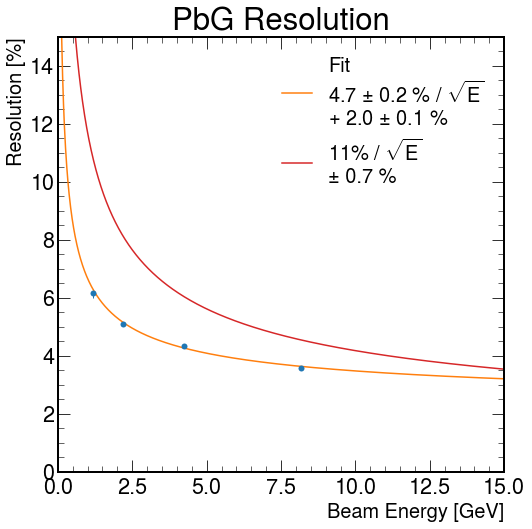

In [87]:
plt.figure(figsize=(8, 8))

plt.errorbar(correctedE(np.array(PbGYield)) + (yb_fit / yA_fit), PbGRes, yerr=PbGResErr, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xlabel("Beam Energy [GeV]", size=20)
plt.ylabel("Resolution [%]", size=20)

initial_params = [0,0]

m = Minuit(LeastSquares(correctedE(np.array(PbGYield)) + (yb_fit / yA_fit), PbGRes, PbGResErr, resolution), A=initial_params[0], b=initial_params[1])
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
A_err = errors['A']
b_fit = fitted_params['b']
b_err = errors['b']
x = np.linspace(0,15,1500)
y_fit = resolution(x, A_fit, b_fit)
plt.plot(x, y_fit, 'tab:orange', label='Fit\n'r'%2.1f ± %2.1f %% / $\sqrt{E}$' '\n$+$ %2.1f ± %2.1f %%'%(A_fit,A_err,b_fit,b_err))

y_old = resolution(x, 11, 0.7)
plt.plot(x, y_old, 'tab:red', label='11% / ' r'$\sqrt{E}$''\n± 0.7 %')

plt.legend(fontsize = 20)

plt.title("PbG Resolution")